In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, json

%matplotlib inline

In [2]:
import pyusct
from pyusct.preprocess import load_usctsim_result, draw_input

In [3]:
from scipy import signal

## parameters

In [4]:
result_path = "/mnt/nas/2018-01-10_2/"

#### load parameters as json

In [5]:
param_path = os.path.join(result_path, 'param.json')
with open(param_path, 'r') as f: param = json.load(f)
print(json.dumps(param, indent=4))

{
    "ringarray": {
        "num_points": 256, 
        "radius": 0.05
    }, 
    "source": {
        "point_map": [
            1, 
            9, 
            17, 
            25, 
            33, 
            41, 
            49, 
            57, 
            65, 
            73, 
            81, 
            89, 
            97, 
            105, 
            113, 
            121, 
            129, 
            137, 
            145, 
            153, 
            161, 
            169, 
            177, 
            185, 
            193, 
            201, 
            209, 
            217, 
            225, 
            233, 
            241, 
            249
        ], 
        "waveform": {
            "wavenum": 1, 
            "magnitude": 50, 
            "type": "sinusoidal", 
            "freq": 2000000.0, 
            "wavenum_offset": 2
        }
    }, 
    "grid": {
        "Nx": 1024, 
        "Ny": 1024, 
        "dx": 0.000125, 
        "dy": 0.000125
    }, 
  

#### load simulation I/O data

In [6]:
param, arr_cart_pos, mask_points, map_speed, map_dens, rfdata = load_usctsim_result(result_path)

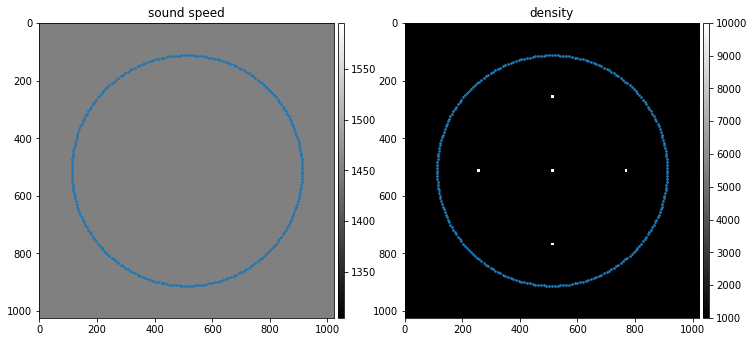

In [7]:
draw_input(mask_points, map_speed, map_dens)

In [8]:
rfdata.data.shape

(32, 256, 4001)

 The shape of the mat rfdata.data is (#source, #sensor, #sampling).

## Time-series preprocessing

In [9]:
rfdata.data -= np.mean(rfdata.data[:,:,0]) # substracting offset pressure

In [10]:
# envelope detection (time consuming ...)
rfdata.data = abs(signal.hilbert(rfdata.data, axis=2))

In [11]:
rfdata.data = (rfdata.data)

## Subset extraction regarding target point

#### Example target point (the center of the ring)

In [12]:
target = [0.0, 0.0]

In [13]:
map_time_pos, subset = rfdata.getPointSubset(target, np.arange(-100, 100, 1))

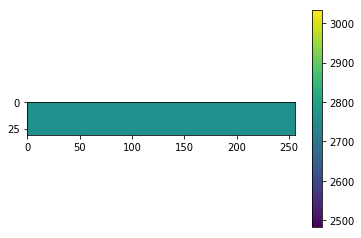

In [14]:
plt.imshow(map_time_pos, interpolation='nearest')
plt.colorbar()

(-0.001, 0.001)

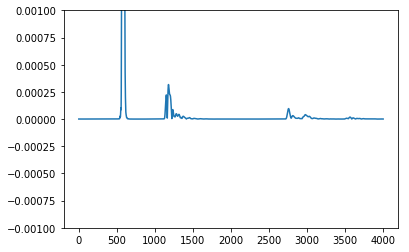

In [15]:
plt.plot(rfdata.data[2,0,:])
plt.ylim(-0.001, 0.001)

2758


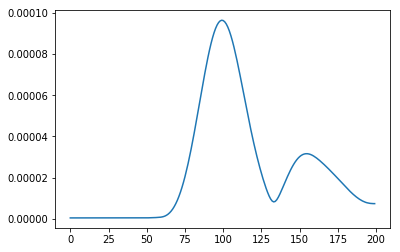

In [16]:
print map_time_pos[2,0]
plt.plot(subset[2,0,:])
#plt.ylim(-0.001, 0.001)

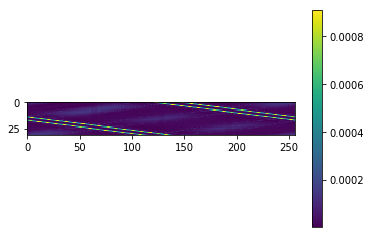

In [17]:
plt.imshow(subset[:,:,100])
plt.colorbar()

#### Another example regarding different point

4129


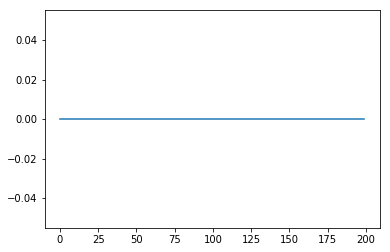

In [18]:
target = [0.02, 0.02]
map_time_pos, subset = rfdata.getPointSubset(target, np.arange(-100, 100, 1))
print map_time_pos[2,0]
plt.plot(subset[2,0,:])

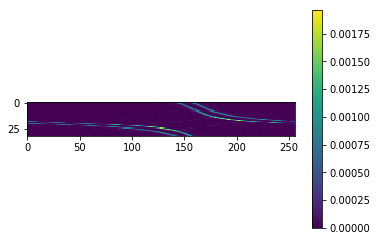

In [19]:
plt.imshow(subset[:,:,100])
plt.colorbar()

## Synthetic aperture

In [20]:
c = 16 # compression rate

out_image = np.zeros((param["grid"]["Ny"]/c, param["grid"]["Nx"]/c))

for iy in range(0, param["grid"]["Ny"], c):
    print '.',
    for ix in range(0, param["grid"]["Nx"], c):
        y = (iy - param["grid"]["Ny"]/2) * param["grid"]["dy"]
        x = (ix - param["grid"]["Nx"]/2) * param["grid"]["dx"]
        
        _, submat = rfdata.getPointSubset([y, x]) # no time range
        out_image[iy/c, ix/c] = np.sum(submat[:,:,0]) # summation of envelope

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


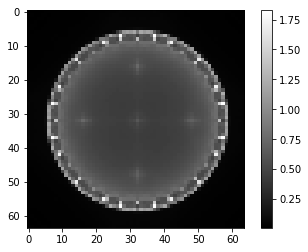

In [21]:
plt.imshow(out_image, interpolation='nearest', cmap='gray')
plt.colorbar()